In [146]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'laptop-selection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2925330%2F5039655%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240520%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240520T173808Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D058ad0bc5262999fd97e351818e729c42c1d8961c0ecfe6fa8122bd15f3d15db531bd3a6f7b59f1ff34e58bbbbe9972722f89bb61c433cc9f312e925500004c85e2c2214201bad3750070b8fc99a44c83403a41e6ef329e9ed3fdcf5bfeeaa0c00d7df8f870a9b29c3582d1a0fb8f7e55ca89d3131dcb4056a2303dcd1de33c999469e3403e5dbbe32da0e19e0f46484565ac8c023eb270a4113f99ed248396cce2e1039a847f4d2869074ca8a6b9001c1ee0a69842b28f1eb8c813011619a1dda5519cde3a2095426d149009a2e98b09313b58af214c67ab30fe3dae80699d95ba1ca84f6007265c79412ae673f89351fdb7dfc69ea06dcb09b7df7c02ef33c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 40089 bytes downloaded
Downloaded and uncompressed: laptop-selection-dataset
Data source import complete.


# **Постановка задачи**

Пусть мы хотим выпустить ноутбук, но для этого нужно понимать оптимальные параметры для него. Следовательно, основываясь на пользовательском рейтинге, нам нужно выбрать оптимальную ОС, размер хранилища и т. п.

# **Загрузка данных**

In [147]:
import numpy as np
import pandas as pd

In [148]:
df = pd.read_csv('/kaggle/input/laptop-selection-dataset/laptops.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        984 non-null    int64  
 1   img_link          984 non-null    object 
 2   name              984 non-null    object 
 3   price(in Rs.)     984 non-null    int64  
 4   processor         984 non-null    object 
 5   ram               984 non-null    object 
 6   os                984 non-null    object 
 7   storage           984 non-null    object 
 8   display(in inch)  984 non-null    float64
 9   rating            688 non-null    float64
 10  no_of_ratings     688 non-null    float64
 11  no_of_reviews     688 non-null    float64
dtypes: float64(4), int64(2), object(6)
memory usage: 92.4+ KB


In [149]:
df.sample(3)
# no_of_rating - количество пользователей, оценивших ноутбук
# no_of_reviews - количество пользователей, оставивших отзыв на ноутбук

,Unnamed: 0,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews
804,804,https://rukminim1.flixcart.com/image/312/312/x...,ASUS Core i9 11th Gen,88990,Intel Core i9 Processor (11th Gen),16 GB DDR4 RAM,Windows 11 Operating System,512 GB SSD,15.6,NaN,NaN,NaN
749,749,https://rukminim1.flixcart.com/image/312/312/k...,Lenovo IdeaPad 3 Dual Core 3020e,27990,AMD Dual Core Processor,4 GB DDR4 RAM,64 bit Windows 11 Operating System,256 GB SSD,14.0,4.1,114.0,15.0
741,741,https://rukminim1.flixcart.com/image/312/312/l...,ASUS VivoBook K15 OLED (2022) Core i5 11th Gen,63990,Intel Core i5 Processor (11th Gen),16 GB DDR4 RAM,64 bit Windows 10 Operating System,1 TB HDD|256 GB SSD,15.6,4.3,652.0,85.0


# **Обработка данных**

In [150]:
# Нулевая колонка бесполезна, так что удалим её
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head(3)

,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews
0,https://rukminim1.flixcart.com/image/312/312/x...,Lenovo Intel Core i5 11th Gen,62990,Intel Core i5 Processor (11th Gen),16 GB DDR4 RAM,Windows 11 Operating System,512 GB SSD,15.6,4.5,14.0,1.0
1,https://rukminim1.flixcart.com/image/312/312/x...,Lenovo V15 G2 Core i3 11th Gen,37500,Intel Core i3 Processor (11th Gen),8 GB DDR4 RAM,64 bit Windows 11 Operating System,1 TB HDD|256 GB SSD,15.6,4.4,53.0,3.0
2,https://rukminim1.flixcart.com/image/312/312/l...,ASUS TUF Gaming F15 Core i5 10th Gen,49990,Intel Core i5 Processor (10th Gen),8 GB DDR4 RAM,Windows 11 Operating System,512 GB SSD,15.6,4.4,4733.0,463.0


In [151]:
df.isna().mean()

img_link            0.000000
name                0.000000
price(in Rs.)       0.000000
processor           0.000000
ram                 0.000000
os                  0.000000
storage             0.000000
display(in inch)    0.000000
rating              0.300813
no_of_ratings       0.300813
no_of_reviews       0.300813
dtype: float64

In [152]:
# Отбросим данные без рейтинга пользователей, т.к. мы собираемся основывать выбор на рейтинге
df.dropna(inplace=True)
df.isna().mean()

img_link            0.0
name                0.0
price(in Rs.)       0.0
processor           0.0
ram                 0.0
os                  0.0
storage             0.0
display(in inch)    0.0
rating              0.0
no_of_ratings       0.0
no_of_reviews       0.0
dtype: float64

In [153]:
df = df.sort_values('rating', ascending=False)
df.head(3)

,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews
609,https://rukminim1.flixcart.com/image/312/312/k...,ASUS ExpertBook B9 Core i7 10th Gen,154990,Intel Core i7 Processor (10th Gen),16 GB LPDDR3 RAM,64 bit Windows 10 Operating System,1 TB SSD,14.0,5.0,3.0,0.0
111,https://rukminim1.flixcart.com/image/312/312/x...,HP Pavilion Ryzen 5 Hexa Core 5625U,61990,AMD Ryzen 5 Hexa Core Processor,16 GB DDR4 RAM,64 bit Windows 11 Operating System,512 GB SSD,14.0,5.0,3.0,1.0
262,https://rukminim1.flixcart.com/image/312/312/l...,ASUS ROG Strix SCAR 15 (2022) Core i9 12th Gen,281990,Intel Core i9 Processor (12th Gen),32 GB DDR5 RAM,64 bit Windows 11 Operating System,1 TB SSD,15.6,5.0,4.0,0.0


In [154]:
# Проверим на дубликаты
df.duplicated().value_counts()

False    531
True     157
Name: count, dtype: int64

In [155]:
# Удалим дубликаты
df.drop_duplicates(inplace=True)
df.duplicated().value_counts()

False    531
Name: count, dtype: int64

In [156]:
df['storage'].value_counts()

storage
512 GB SSD                                                                                                                                                                                                              321
256 GB SSD                                                                                                                                                                                                               73
1 TB SSD                                                                                                                                                                                                                 62
1 TB HDD|256 GB SSD                                                                                                                                                                                                      27
1 TB HDD                                                                                                        

In [157]:
# df.drop(labels=df[df['storage'].str.len() >= 30], inplace=True, axis=1)
# Пока что костыль :)
df[df['storage'] == 'PCI-e Gen4 SSD?SHIFT?Matrix Display (Extend)?Cooler Boost 3?Thunderbolt 4?Finger Print Security?True Color 2.0?Hi-Res Audio?Nahimic 3? 4-Sided Thin bezel?MSI Center?Silky Smooth Touchpad?Military-Grade Durability']
df = df.drop([698], axis=0)
df[df['storage'] == 'PCI-e SSD (NVMe) ready,Silver-Lining Print Keyboard,Matrix Display (Extend),Cooler Boost 5,Hi-Res Audio,Nahimic 3,144Hz Panel,Thin Bezel,RGB Gaming Keyboard,Speaker Tuning Engine,MSI Center']
df = df.drop([595], axis=0)

# **Анализ данных**

In [158]:
# Классифицируем по рейтингу. Создадим новый столбец со значениями "0" - рейтинг
# меньше 4.0, "1" - рейтинг лежит в промежутке [4.0, 4.5], "2" - рейтинг больше 4.5
def fill_conditions(row):
    if row['rating'] < 4.0:
        return 0
    elif row['rating'] < 4.5:
        return 1
    elif row['rating'] < 5.0:
        return 2
    else:
        return 3
df['accountability'] = df.apply(fill_conditions, axis=1)
df.sample(3)

,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews,accountability
904,https://rukminim1.flixcart.com/image/312/312/k...,MSI GF63 Thin Core i7 9th Gen,66990,Intel Core i7 Processor (9th Gen),8 GB DDR4 RAM,64 bit Windows 10 Operating System,512 GB SSD,15.6,4.5,1667.0,232.0,2
276,https://rukminim1.flixcart.com/image/312/312/l...,MSI Crosshair 15 Core i7 12th Gen,104990,Intel Core i7 Processor (12th Gen),16 GB DDR4 RAM,64 bit Windows 11 Operating System,512 GB SSD,15.6,4.6,14.0,1.0,2
869,https://rukminim1.flixcart.com/image/312/312/k...,DELL Core i7 11th Gen,99900,Intel Core i7 Processor (11th Gen),16 GB DDR4 RAM,64 bit Windows 11 Operating System,512 GB SSD,14.0,4.5,28.0,3.0,2


In [159]:
import seaborn as sns

<Axes: xlabel='accountability', ylabel='count'>

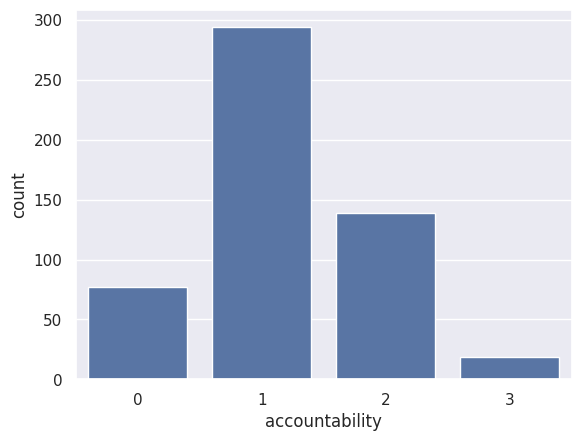

In [160]:
# Посмотрим на распределение оценок по новой классификации
sns.countplot(data=df, x = 'accountability')

Видим, что оценок 5.0 почти нет, оценок выше 4.5 не так много по сравнению с оценками от 4.0 до 4.5
Но каждая эта оценка является средним арифметическим оценок пользователей

[Text(0.5, 0, 'Amount of ratings'), Text(0, 0.5, 'Count amounts')]

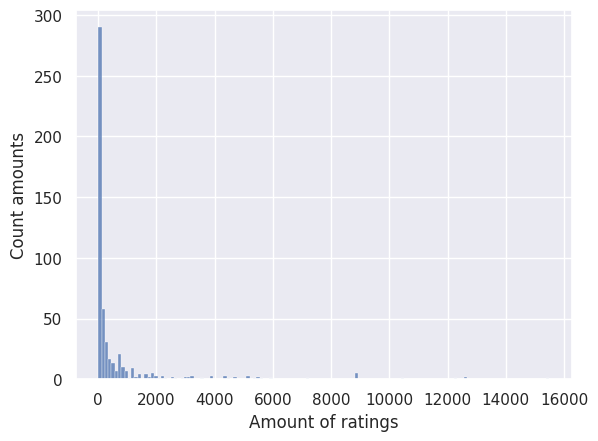

In [161]:
sns.histplot(data=df, x='no_of_ratings').set(xlabel='Amount of ratings', ylabel='Count amounts')

Видим, что у большинства ноутбуков количество оценок ниже 2000 и распределение сильно ассимметричное.  Логично считать оценку тем более достоверной, чем больше людей оценило ноутбук. Поэтому введём вес оценки. Возьмём медиану и нормируем на неё оценку следующим образом: если количество отзывов >= медианы, то вес равен 1, иначе вес равен (количество оценок)/медиана.

In [162]:
def weight(row):
    median = df['no_of_ratings'].median()
    if row['no_of_ratings'] >= median:
        return row['rating']
    else:
        return row['rating'] * row['no_of_ratings']/median

df['weight_rating'] = df.apply(weight, axis=1)
df.sample(3)

,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews,accountability,weight_rating
210,https://rukminim1.flixcart.com/image/312/312/x...,ASUS Vivobook 14 (2022) Core i3 12th Gen,46990,Intel Core i3 Processor (12th Gen),8 GB DDR4 RAM,64 bit Windows 11 Operating System,512 GB SSD,14.0,4.2,12.0,2.0,1,0.579310
225,https://rukminim1.flixcart.com/image/312/312/x...,DELL Core i5 12th Gen,76519,Intel Core i5 Processor (12th Gen),8 GB DDR4 RAM,64 bit Windows 11 Operating System,512 GB SSD,14.0,4.5,4.0,1.0,2,0.206897
857,https://rukminim1.flixcart.com/image/312/312/k...,ASUS Vivobook Gaming Core i7 10th Gen,65990,Intel Core i7 Processor (10th Gen),8 GB DDR4 RAM,64 bit Windows 10 Operating System,512 GB SSD,15.6,4.3,76.0,7.0,1,3.756322


<Axes: xlabel='weight_accountability', ylabel='count'>

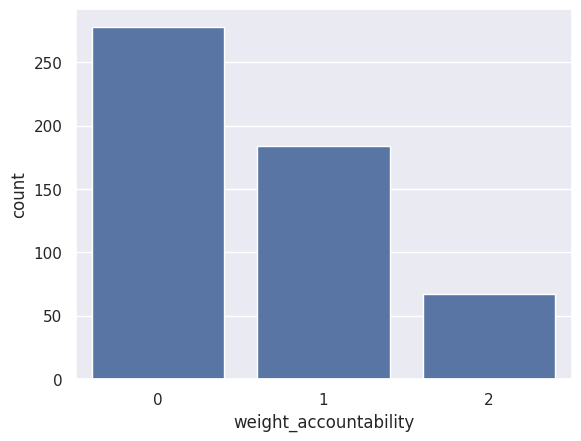

In [163]:
def weight_fill_cond(row):
    if row['weight_rating'] < 4.0:
        return 0
    elif row['weight_rating'] < 4.5:
        return 1
    elif row['weight_rating'] < 5.0:
        return 2
    else:
        return 3

df['weight_accountability'] = df.apply(weight_fill_cond, axis=1)

sns.countplot(data=df, x = 'weight_accountability')

Как мы видим, наиболее высокие оценки ставят мало человек. Посмотрим какие ноутбуки со взвешенной оценкой больше либо равной 4.5 (если взять строгое равенство, то получится примерно в 2.5 раза меньше ноутбуков с weight_accountability = 2) выбирали люди

<ipython-input-164-c615044d9d3d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
<ipython-input-164-c615044d9d3d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
<ipython-input-164-c615044d9d3d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
<ipython-input-164-c615044d9d3d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
<ipython-input-164-c615044d9d3d>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


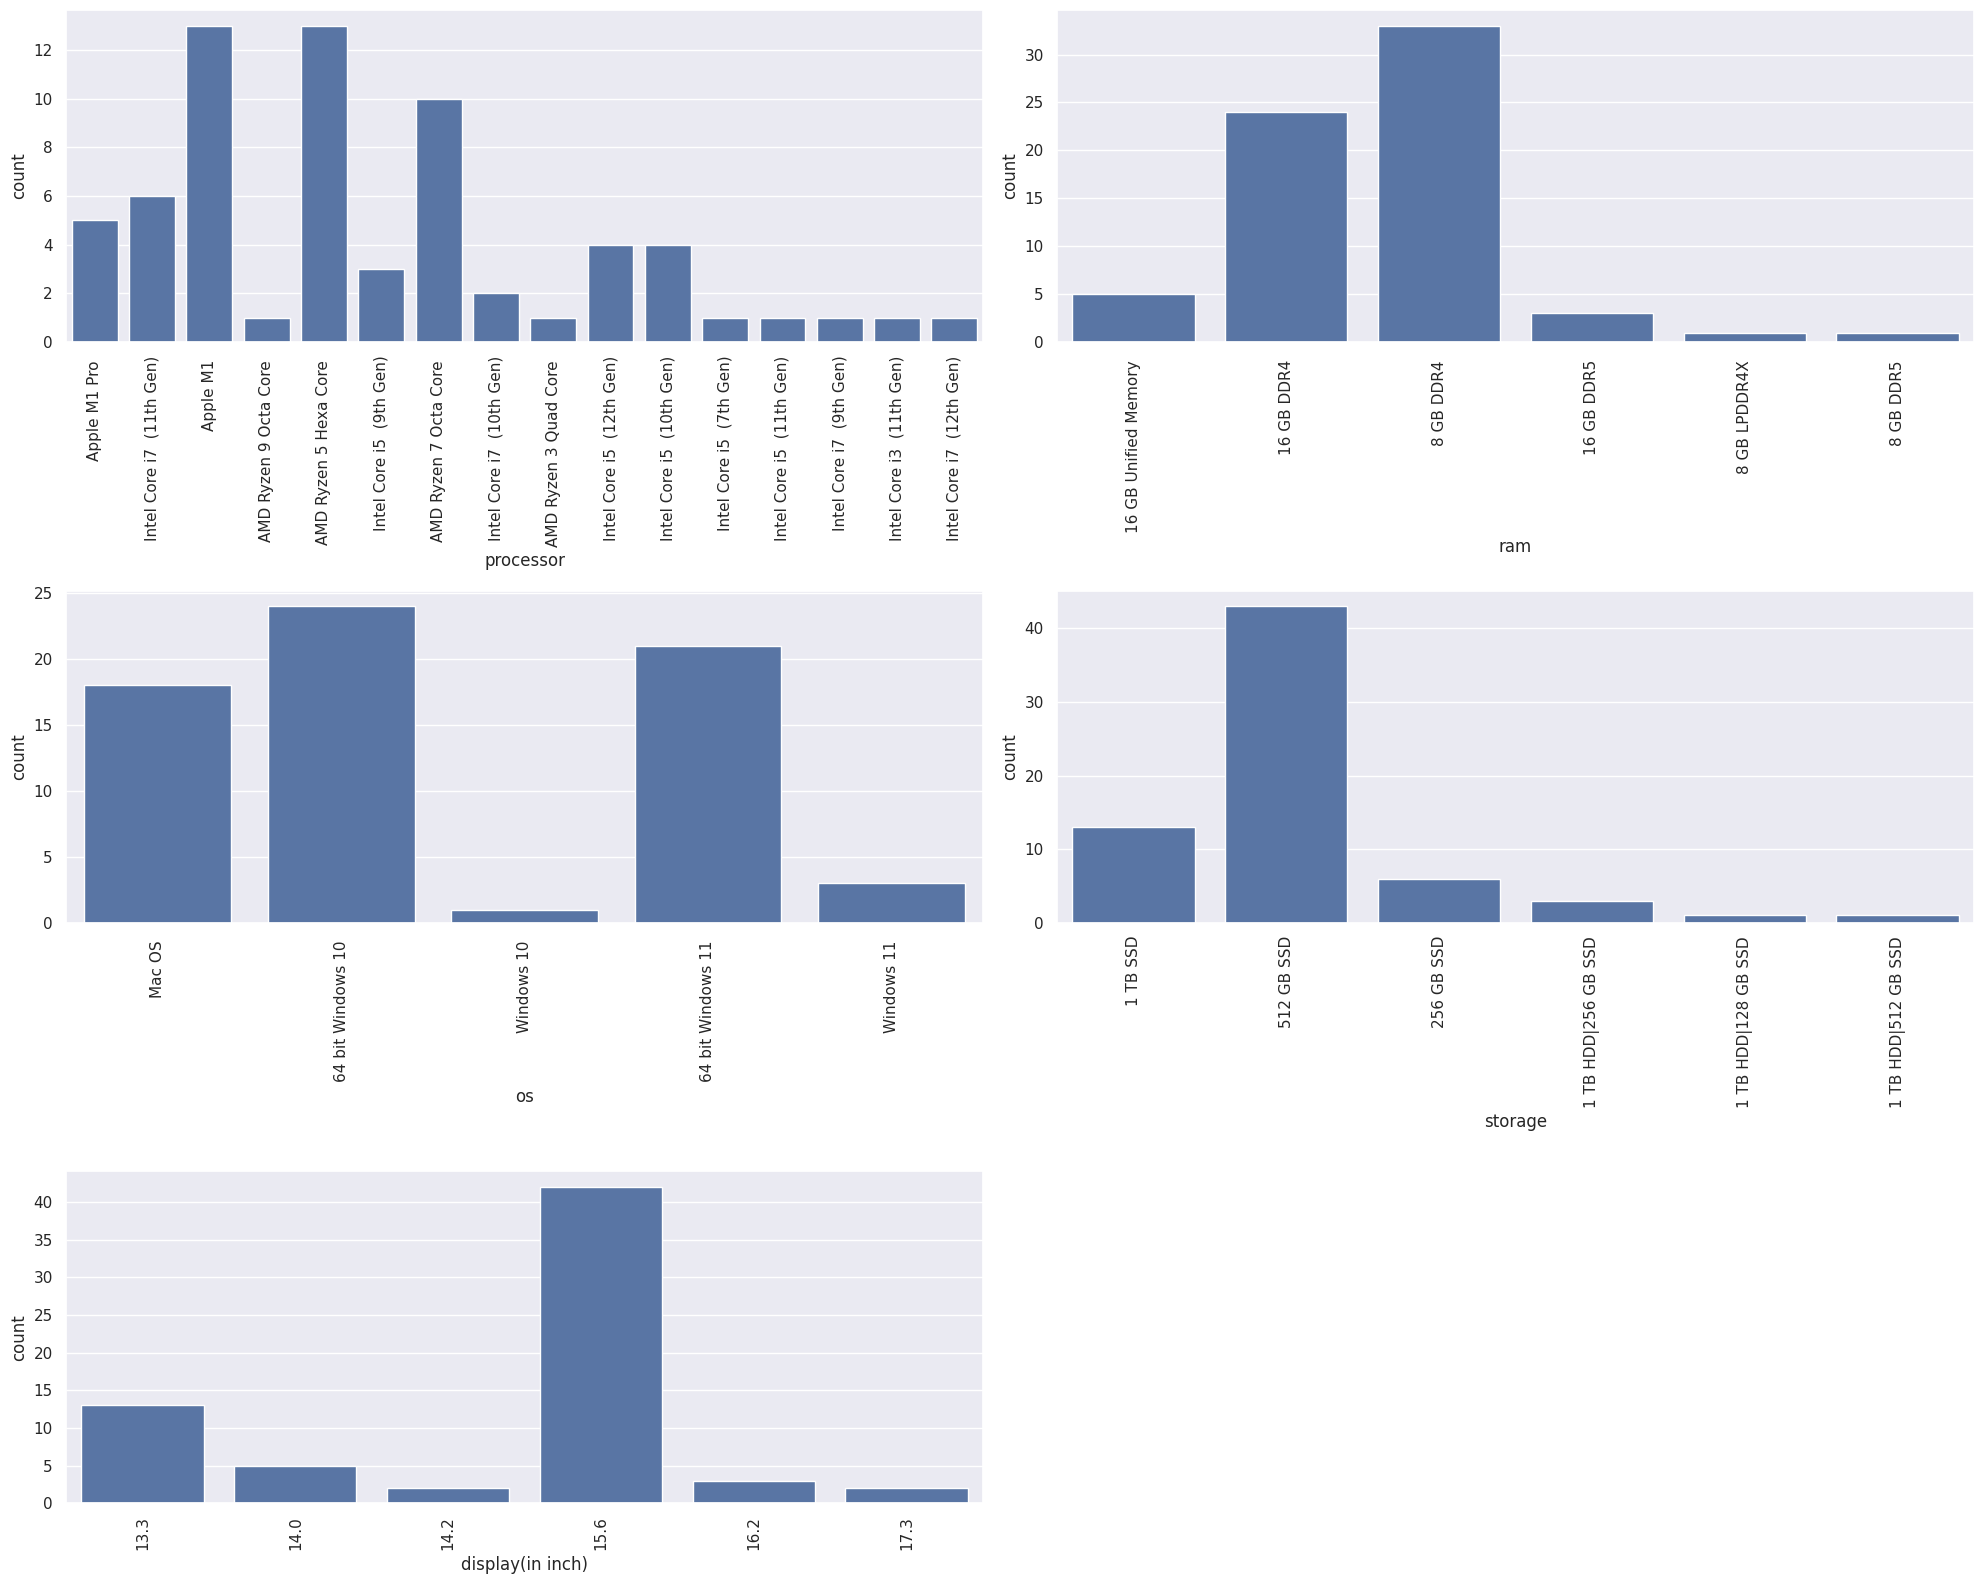

In [164]:
import matplotlib.pyplot as plt


characteristics = ['processor', 'ram', 'os', 'storage', 'display(in inch)']
dff = df[df['weight_accountability'] == 2][characteristics]
dff['processor'] = dff['processor'].str.replace("Processor", "")
dff['os'] = dff['os'].str.replace("Operating System", "")
dff['ram'] = dff['ram'].str.replace('RAM', '')
fig = plt.figure(figsize=(20, 16))

j = 1
for i in range(len(characteristics)):
    plt.subplot(3, 2, j)
    # !!!Настроить отображение значений по оси х!!!
    ax = sns.countplot(data=dff, x=characteristics[i])

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    j += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.3,
                    wspace=0.4,
                    hspace=0.5)

plt.tight_layout()
plt.show()

In [165]:
# Видим ,что у процессора 2 моды, а значит ноутбуки будут различаться только процессором
dff.mode().fillna(method='ffill')

,processor,ram,os,storage,display(in inch)
0,AMD Ryzen 5 Hexa Core,8 GB DDR4,64 bit Windows 10,512 GB SSD,15.6
1,Apple M1,8 GB DDR4,64 bit Windows 10,512 GB SSD,15.6


# **Матрица корреляции**

[]

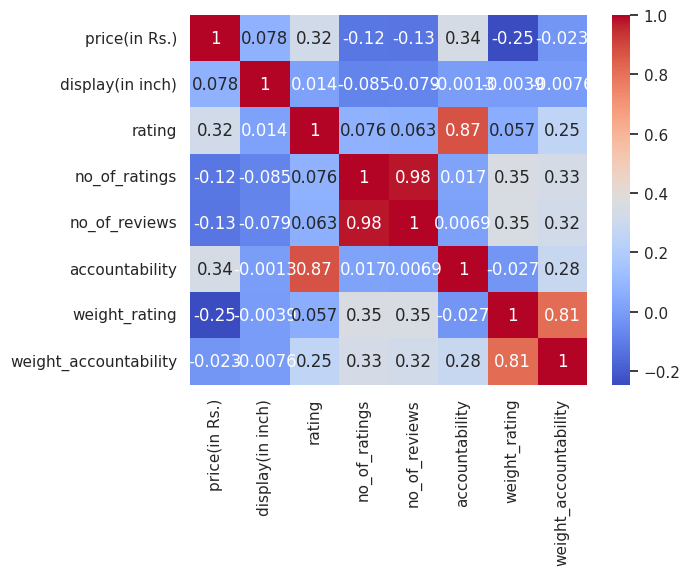

In [166]:
numerical_data = df.select_dtypes(include=[np.number])
sns.heatmap(data=numerical_data.corr(), annot=True, cmap='coolwarm')
plt.plot()

Из матрицы корреляции видно, что очень сильная линейная корреляция между числом оценок и числом отзывов. Это означает, что почти каждый поставивший оценку человек оставил ещё и отзыв. Все остальные колонки, имеющие сильную корреляцию - это введённые колонки на основе существующих, с которым собственно высокая корреляция.

# **Вывод**

Покупателям больше всего нравятся ноутбуки с 8 GB DDR4 RAM, 512 GB SSD, 15.6 inch display, 64 bit Windows 10 OS, а также с процессорами AMD Ryzen 5 Hexa Core Processor и Apple M1 Processor.
Поэтому наиболее логично будет делать ноутбук с такими комплектующими